<a href="https://colab.research.google.com/github/elangarka/Regularized-Xception-FER-Extra-Training-Data-Step-Decay-Learning-Rate/blob/main/Regularized_Xception_FER_ExtraTrainingData_StepDecay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Library

In [ ]:
# Import packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping


# Import Dataset

In [ ]:
data = pd.read_csv('fer+ck+augmentedfer.csv')
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


## Organize Data


In [ ]:
# Process the third column to convert pixel strings to arrays
data['pixels'] = data[' pixels'].apply(lambda x: np.array(x.split(), dtype=np.float32) / 255.0)


In [ ]:
# Select the second column (index 1) as the splitter column
splitter_column = data.iloc[:, 1]

In [ ]:
# Split the dataset based on the values in the second column
train_data = data[splitter_column == 'Training']
validation_data = data[splitter_column == 'PublicTest']
test_data = data[splitter_column == 'PrivateTest']

#Preprocessing Data

In [ ]:
# Preprocess the data (reshape and normalize)
def preprocess_data(data):
    images = np.array(data['pixels'].tolist()).reshape(-1, 48, 48, 1)
    return images

X_train = preprocess_data(train_data)
X_validation = preprocess_data(validation_data)
X_test = preprocess_data(test_data)

y_train = to_categorical(train_data['emotion'], num_classes=7)
y_validation = to_categorical(validation_data['emotion'], num_classes=7)
y_test = to_categorical(test_data['emotion'], num_classes=7)

## Augmentation Data

In [ ]:
# Create an image generator for augmentation
train_datagen = ImageDataGenerator(
    rotation_range = 30,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

In [ ]:
# Menampilkan jumlah data untuk setiap label
print("Jumlah data pada set pelatihan:")
print(train_datagen)

Jumlah data pada set pelatihan:


## Setup Model Xception

In [ ]:
def entry_flow(inputs):

  x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(64, 3, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  previous_block_activation = x  # Set aside residual

  # Blocks 1, 2, 3 are identical apart from the feature depth.
  for size in [128, 256, 728]:
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    residual = layers.Conv2D(  # Project residual
        size, 1, strides=2, padding='same')(previous_block_activation)
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

  return x





In [ ]:
def middle_flow(x, num_blocks=8):

  previous_block_activation = x

  for _ in range(num_blocks):
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(728, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(728, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(728, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.add([x, previous_block_activation])  # Add back residual
    previous_block_activation = x  # Set aside next residual


  return x


In [ ]:

def exit_flow(x, num_classes=7):

  previous_block_activation = x

  x = layers.Activation('relu')(x)
  x = layers.SeparableConv2D(728, 3, padding='same')(x)
  x = layers.BatchNormalization()(x)

  x = layers.Activation('relu')(x)
  x = layers.SeparableConv2D(1024, 3, padding='same')(x)
  x = layers.BatchNormalization()(x)

  x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

  residual = layers.Conv2D(  # Project residual
      1024, 1, strides=2, padding='same')(previous_block_activation)
  x = layers.add([x, residual])  # Add back residual

  x = layers.SeparableConv2D(1536, 3, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.SeparableConv2D(2048, 3, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.GlobalAveragePooling2D()(x)
  if num_classes == 1:
    activation = 'sigmoid'
  else:
    activation = 'softmax'
  return layers.Dense(num_classes, activation=activation, kernel_regularizer=regularizers.l2(0.01))(x)

inputs = keras.Input(shape=(48, 48, 1))  # Variable-size image inputs.
outputs = exit_flow(middle_flow(entry_flow(inputs)))
xception = keras.Model(inputs, outputs)

In [ ]:
#cnn = xception
xception.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 24, 24, 32)           320       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_36 (Ba  (None, 24, 24, 32)           128       ['conv2d_6[0][0]']            
 tchNormalization)                                                                                
                                                                                                  
 activation_36 (Activation)  (None, 24, 24, 32)           0         ['batch_normalization_36[0

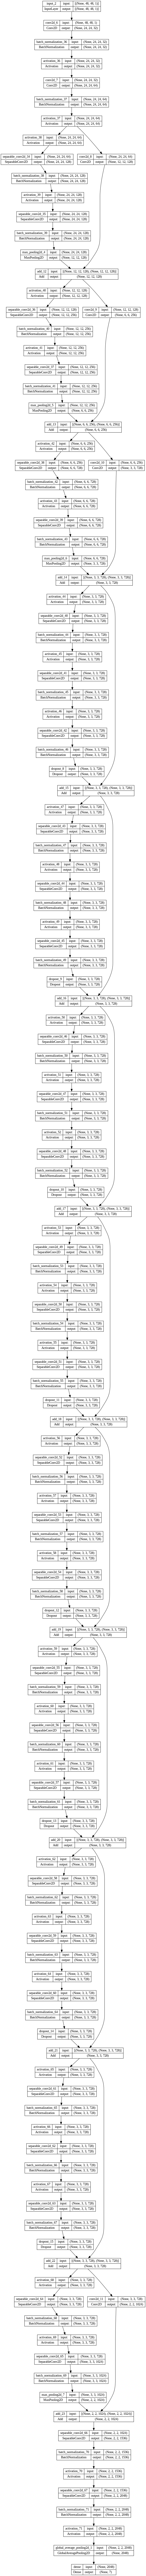

In [ ]:

plot_model(xception, to_file='/content/drive/MyDrive/model.png', show_shapes=True, show_layer_names=True)


## Training Configuration

In [ ]:
# Set up the optimizer
opt = tf.keras.optimizers.Adam(0.001)
xception.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
# Define ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint('bestXceptionPlusData.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [ ]:
# Train the model using the training and validation data with data augmentation
batch_size = 64
train_loader = train_datagen.flow(X_train, y_train, batch_size=batch_size)
validation_loader = (X_validation, y_validation)  # No data augmentation for validation


In [ ]:
# Menampilkan jumlah data untuk setiap label
print("Jumlah data pada set pelatihan:")
print(train_loader)

Jumlah data pada set pelatihan:


# First Training

In [ ]:
# Fit the model using .fit
epochs = 100
h1 = xception.fit(train_loader, steps_per_epoch=len(X_train) // batch_size,
                    validation_data=validation_loader, epochs=epochs, callbacks=[checkpoint])

Epoch 1/100
1060/1060 [==============================] - ETA: 0s - loss: 1.7875 - accuracy: 0.3078
Epoch 1: val_accuracy improved from -inf to 0.42630, saving model to /content/drive/MyDrive/DATASET/bestXceptionPlusData2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1060/1060 [==============================] - 117s 76ms/step - loss: 1.7875 - accuracy: 0.3078 - val_loss: 1.5443 - val_accuracy: 0.4263
Epoch 2/100
1060/1060 [==============================] - ETA: 0s - loss: 1.4247 - accuracy: 0.4548
Epoch 2: val_accuracy did not improve from 0.42630
1060/1060 [==============================] - 77s 73ms/step - loss: 1.4247 - accuracy: 0.4548 - val_loss: 1.6063 - val_accuracy: 0.3945
Epoch 3/100
1060/1060 [==============================] - ETA: 0s - loss: 1.2935 - accuracy: 0.5095
Epoch 3: val_accuracy improved from 0.42630 to 0.48036, saving model to /content/drive/MyDrive/DATASET/bestXceptionPlusData2.h5
1060/1060 [==============================] - 80s 75ms/step - loss: 1.2935 - accuracy: 0.5095 - val_loss: 1.3565 - val_accuracy: 0.4804
Epoch 4/100
1060/1060 [==============================] - ETA: 0s - loss: 1.2278 - accuracy: 0.5401
Epoch 4: val_accuracy improved from 0.48036 to 0.53135, saving model to /content/drive/MyDrive/DATASET/bestXceptionPlu

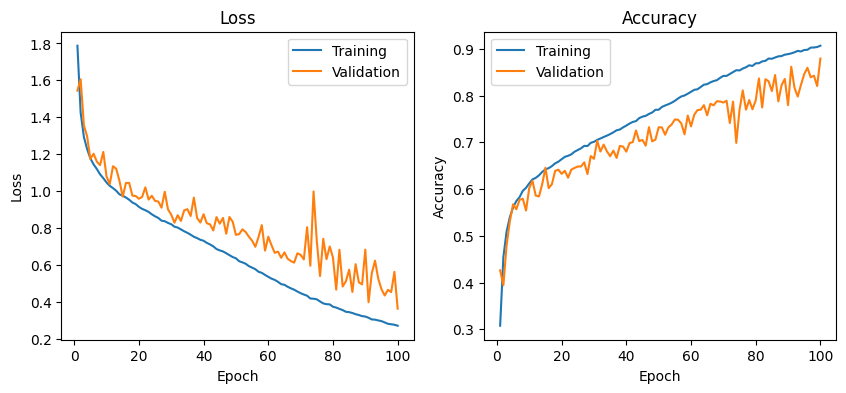

In [ ]:
# Save history and view plots of loss and accuracy
history = h1.history
n_epochs = len(history['loss'])

plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
plt.plot(range(1, n_epochs+1), history['loss'], label='Training')
plt.plot(range(1, n_epochs+1), history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1, n_epochs+1), history['accuracy'], label='Training')
plt.plot(range(1, n_epochs+1), history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.show()

## Second Training


In [ ]:
# Update the learning rate
tf.keras.backend.set_value(xception.optimizer.learning_rate, 0.0001)

In [ ]:
%%time
epochs = 30
# Training Run #2
h2 = xception.fit(train_loader, steps_per_epoch=len(X_train) // batch_size,
                    validation_data=validation_loader, epochs = epochs, callbacks=[checkpoint])

Epoch 1/30
1060/1060 [==============================] - ETA: 0s - loss: 0.1495 - accuracy: 0.9494
Epoch 1: val_accuracy did not improve from 0.92811
1060/1060 [==============================] - 78s 73ms/step - loss: 0.1495 - accuracy: 0.9494 - val_loss: 0.2252 - val_accuracy: 0.9259
Epoch 2/30
1060/1060 [==============================] - ETA: 0s - loss: 0.1474 - accuracy: 0.9511
Epoch 2: val_accuracy did not improve from 0.92811
1060/1060 [==============================] - 78s 74ms/step - loss: 0.1474 - accuracy: 0.9511 - val_loss: 0.2092 - val_accuracy: 0.9273
Epoch 3/30
1060/1060 [==============================] - ETA: 0s - loss: 0.1444 - accuracy: 0.9509
Epoch 3: val_accuracy did not improve from 0.92811
1060/1060 [==============================] - 81s 76ms/step - loss: 0.1444 - accuracy: 0.9509 - val_loss: 0.2278 - val_accuracy: 0.9211
Epoch 4/30
1060/1060 [==============================] - ETA: 0s - loss: 0.1400 - accuracy: 0.9527
Epoch 4: val_accuracy did not improve from 0.92811

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1060/1060 [==============================] - 79s 74ms/step - loss: 0.1404 - accuracy: 0.9528 - val_loss: 0.2085 - val_accuracy: 0.9295
Epoch 6/30
1060/1060 [==============================] - ETA: 0s - loss: 0.1346 - accuracy: 0.9548
Epoch 6: val_accuracy improved from 0.92951 to 0.93313, saving model to /content/drive/MyDrive/DATASET/bestXceptionPlusData2.h5
1060/1060 [==============================] - 84s 79ms/step - loss: 0.1346 - accuracy: 0.9548 - val_loss: 0.2056 - val_accuracy: 0.9331
Epoch 7/30
1060/1060 [==============================] - ETA: 0s - loss: 0.1341 - accuracy: 0.9553
Epoch 7: val_accuracy did not improve from 0.93313
1060/1060 [==============================] - 77s 73ms/step - loss: 0.1341 - accuracy: 0.9553 - val_loss: 0.2030 - val_accuracy: 0.9312
Epoch 8/30
1060/1060 [==============================] - ETA: 0s - loss: 0.1320 - accuracy: 0.9554
Epoch 8: val_accuracy did not improve from 0.93313
1060/1060 [==============================] - 77s 73ms/step - loss: 0.13

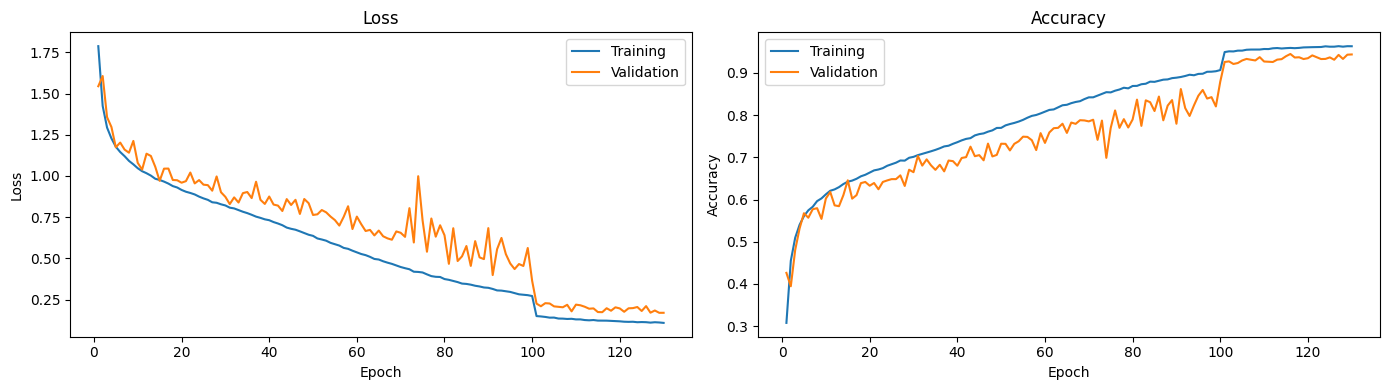

In [ ]:
# Save history and view plots of loss and accuracy
for k in history.keys():
    history[k] += h2.history[k]

epoch_range = range(1, len(history['loss'])+1)

plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
plt.plot(epoch_range, history['loss'], label='Training')
plt.plot(epoch_range, history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch_range, history['accuracy'], label='Training')
plt.plot(epoch_range, history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

## Third Training


In [ ]:
# Update the learning rate
tf.keras.backend.set_value(xception.optimizer.learning_rate, 0.00001)

In [ ]:
%%time

# Training Run #3
epochs = 20
h3 = xception.fit(train_loader, steps_per_epoch=len(X_train) // batch_size,
                    validation_data=validation_loader, epochs=epochs, callbacks=[checkpoint])

Epoch 1/20
1060/1060 [==============================] - ETA: 0s - loss: 0.1041 - accuracy: 0.9645
Epoch 1: val_accuracy did not improve from 0.94483
1060/1060 [==============================] - 73s 69ms/step - loss: 0.1041 - accuracy: 0.9645 - val_loss: 0.1659 - val_accuracy: 0.9448
Epoch 2/20
1060/1060 [==============================] - ETA: 0s - loss: 0.1049 - accuracy: 0.9649
Epoch 2: val_accuracy improved from 0.94483 to 0.94650, saving model to /content/drive/MyDrive/DATASET/bestXceptionPlusData2.h5
1060/1060 [==============================] - 79s 74ms/step - loss: 0.1049 - accuracy: 0.9649 - val_loss: 0.1619 - val_accuracy: 0.9465
Epoch 3/20
1060/1060 [==============================] - ETA: 0s - loss: 0.1016 - accuracy: 0.9660
Epoch 3: val_accuracy did not improve from 0.94650
1060/1060 [==============================] - 72s 68ms/step - loss: 0.1016 - accuracy: 0.9660 - val_loss: 0.1640 - val_accuracy: 0.9440
Epoch 4/20
1060/1060 [==============================] - ETA: 0s - loss:

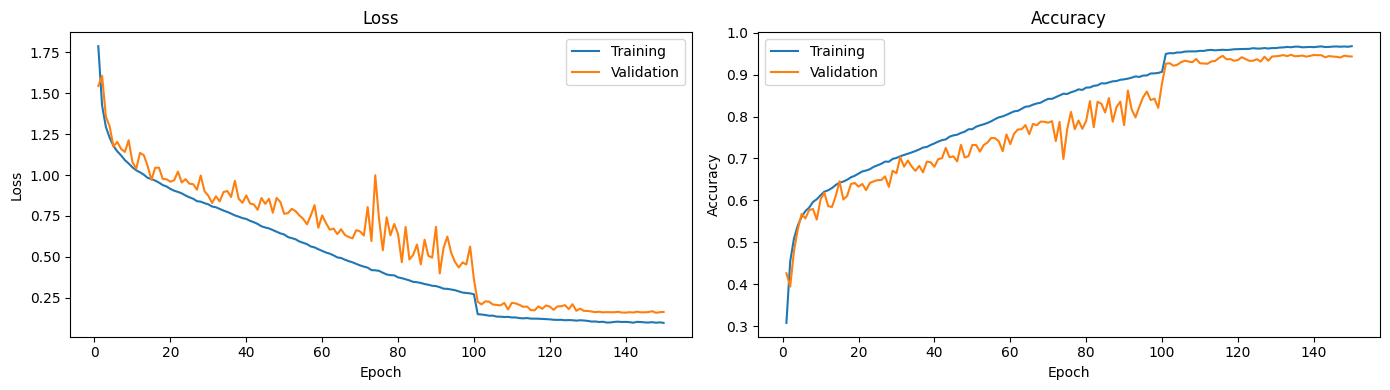

In [ ]:
# Save history and view plots of loss and accuracy
for k in history.keys():
    history[k] += h3.history[k]

epoch_range = range(1, len(history['loss'])+1)

plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
plt.plot(epoch_range, history['loss'], label='Training')
plt.plot(epoch_range, history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch_range, history['accuracy'], label='Training')
plt.plot(epoch_range, history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()